In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

In [2]:
ebValidation <- fread("eb-validation.tsv.gz", stringsAsFactors=TRUE)
ebValidation %>% summary

       Node          Time [s]               Event                   EB       
 node-10 :  122   Min.   :  20.08   EBGenerated:   61   1051-node-135: 1500  
 node-100:  122   1st Qu.: 417.75   EBReceived :45231   1058-node-94 : 1500  
 node-102:  122   Median : 589.61   RBGenerated:   61   1062-node-529: 1500  
 node-103:  122   Mean   : 710.60   ValEB      :45231   1083-node-568: 1500  
 node-104:  122   3rd Qu.:1051.76                       1133-node-94 : 1500  
 node-106:  122   Max.   :1469.88                       1161-node-215: 1500  
 (Other) :89852                                         (Other)      :81584  
        Endorsement   
 254-node-566 :    2  
 401-node-207 :    2  
 428-node-100 :    2  
 1051-node-135:    1  
 1062-node-529:    1  
 (Other)      :   41  
 NA's         :90535  

In [3]:
nodeStake <- fread("node-stake.tsv.gz", stringsAsFactors=TRUE)
nodeStake[, `Stake fraction`:=`Stake`/nodeStake[, sum(`Stake`)]]
nodeStake %>% summary

       Node         Stake          Stake fraction    
 node-0  :  1   Min.   :       0   Min.   :0.000000  
 node-1  :  1   1st Qu.:       0   1st Qu.:0.000000  
 node-10 :  1   Median :       0   Median :0.000000  
 node-100:  1   Mean   :16929522   Mean   :0.001333  
 node-101:  1   3rd Qu.:44196969   3rd Qu.:0.003481  
 node-102:  1   Max.   :78570315   Max.   :0.006188  
 (Other) :744                                        

In [4]:
nodeStake[, sum(`Stake fraction`)]

[1] 1

In [5]:
nodeCount <- nrow(nodeStake)
nodeCount

[1] 750

In [6]:
generated <- ebValidation[`Event` == "RBGenerated", .(`Node`, `EB`, `Generated [s]`=`Time [s]`)]
generated %>% summary

       Node                EB     Generated [s]    
 node-91 : 3   1051-node-135: 1   Min.   :  20.08  
 node-151: 2   1058-node-94 : 1   1st Qu.: 417.26  
 node-487: 2   1062-node-529: 1   Median : 589.17  
 node-528: 2   1083-node-568: 1   Mean   : 707.00  
 node-580: 2   1133-node-94 : 1   3rd Qu.:1051.16  
 node-584: 2   1161-node-215: 1   Max.   :1468.16  
 (Other) :48   (Other)      :55                    

In [7]:
generationToValidation <-
    rbind(
        generated[nodeStake[ebValidation, on="Node"], on="EB"][
            `Event` == "ValEB",
            .(
                `EB`,
                `Generated [s]`,
                `Node`,
                `Node fraction`=1/nodeCount,
                `Stake fraction`,
                `Time from generation to validation [s]`=`Time [s]`-`Generated [s]`
            )
        ],
        generated[nodeStake, on="Node", nomatch=NULL][
            ,
            .(
                `EB`,
                `Generated [s]`,
                `Node`,
                `Node fraction`=1/nodeCount,
                `Stake fraction`,
                `Time from generation to validation [s]`=0
            )
        ]
    )[order(`EB`, `Generated [s]`, `Time from generation to validation [s]`)][
        ,
        .(
            `Generated [s]`, 
            `Node`, 
            `Time from generation to validation [s]`,
            `Cumulative fraction of nodes`=cumsum(`Node fraction`),
            `Cumulative fraction of stake`=cumsum(`Stake fraction`)
            ),
        .(`EB`)
    ]
generationToValidation %>% summary

             EB        Generated [s]           Node      
 1051-node-135:  750   Min.   :  20.08   node-91 : 2250  
 1058-node-94 :  750   1st Qu.: 417.26   node-151: 1500  
 1062-node-529:  750   Median : 589.17   node-487: 1500  
 1083-node-568:  750   Mean   : 709.93   node-528: 1500  
 1133-node-94 :  750   3rd Qu.:1051.16   node-580: 1500  
 1161-node-215:  750   Max.   :1468.16   node-584: 1500  
 (Other)      :40792                     (Other) :35542  
 Time from generation to validation [s] Cumulative fraction of nodes
 Min.   :0.0000                         Min.   :0.001333            
 1st Qu.:0.2505                         1st Qu.:0.248000            
 Median :0.5788                         Median :0.497333            
 Mean   :0.6788                         Mean   :0.498698            
 3rd Qu.:0.9455                         3rd Qu.:0.749333            
 Max.   :3.3192                         Max.   :1.000000            
                                                     

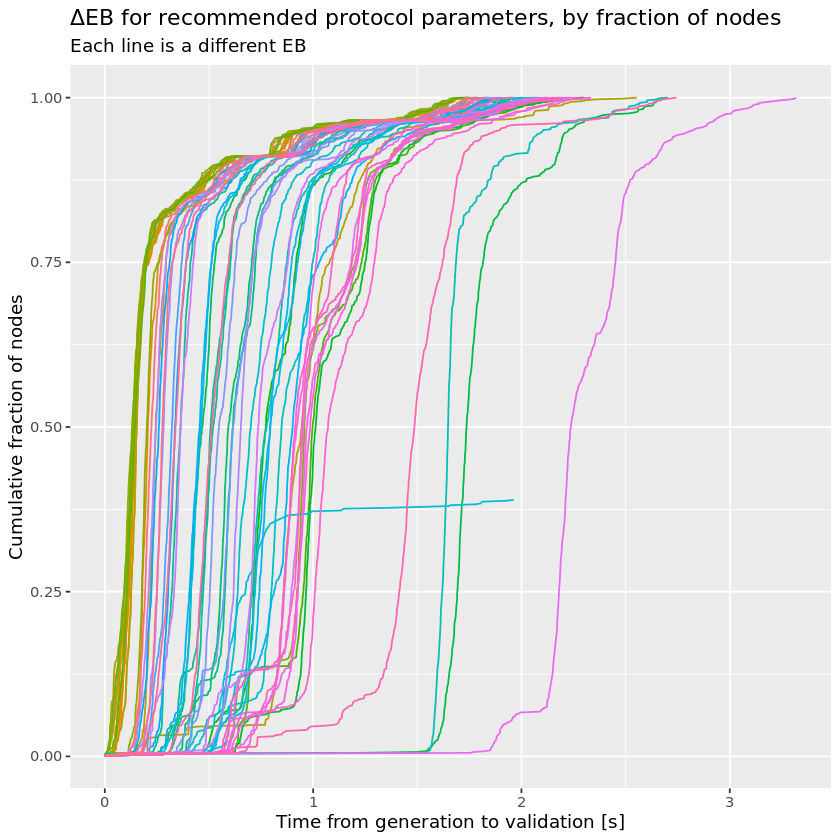

In [8]:
ggplot(
    generationToValidation,
    aes(x=`Time from generation to validation [s]`, y=`Cumulative fraction of nodes`, color=`EB`)
) +
    geom_line() +
    theme(legend.position = "none") +
    ggtitle("ΔEB for recommended protocol parameters, by fraction of nodes", "Each line is a different EB")

In [9]:
ggsave("delta-eb-by-nodes.png", units="in", dpi=150, width=8, height=6)

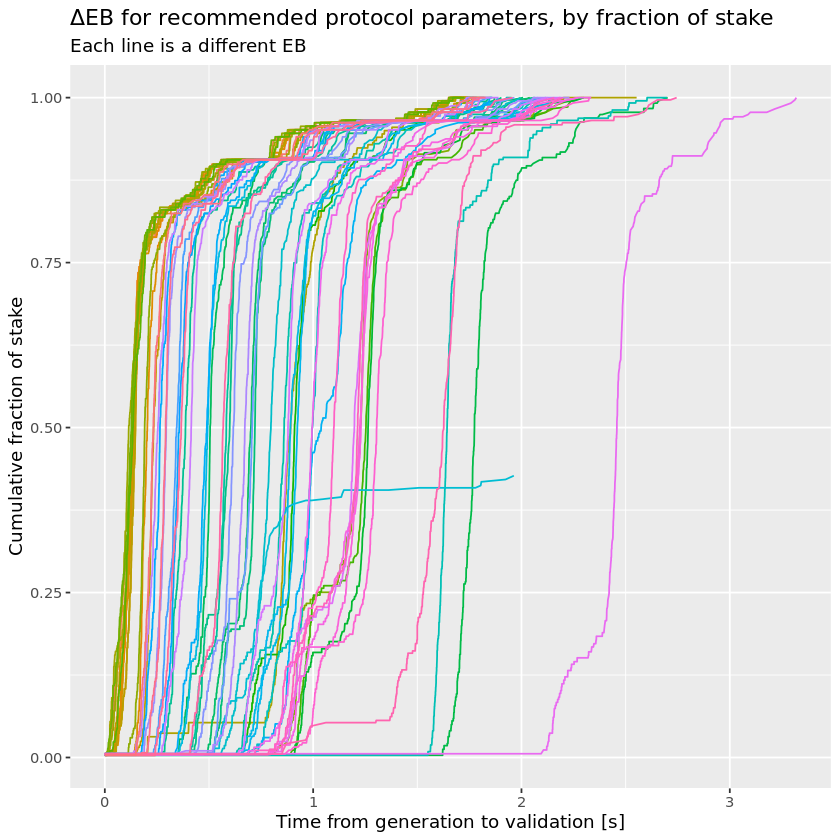

In [10]:
ggplot(
    generationToValidation,
    aes(x=`Time from generation to validation [s]`, y=`Cumulative fraction of stake`, color=`EB`)
) +
    geom_line() +
    theme(legend.position = "none") +
    ggtitle("ΔEB for recommended protocol parameters, by fraction of stake", "Each line is a different EB")

In [11]:
ggsave("delta-eb-by-stake.png", units="in", dpi=150, width=8, height=6)

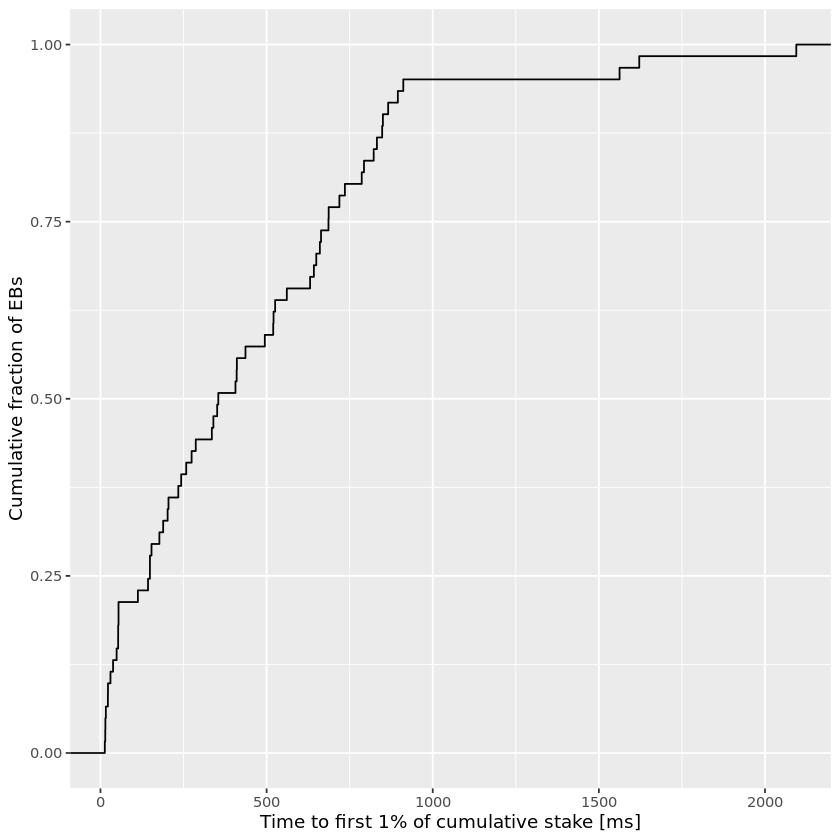

In [12]:
ggplot(
    generationToValidation[
        `Cumulative fraction of stake` <= 0.01, 
        .(`Time to first 1% of cumulative stake [ms]`=1000*max(`Time from generation to validation [s]`)), 
        .(`EB`)
    ],
    aes(x=`Time to first 1% of cumulative stake [ms]`)
) +
    stat_ecdf() +
    ylab("Cumulative fraction of EBs")

In [13]:
ggsave("first-1percent.png", units="in", dpi=150, width=8, height=6)